In [1]:
import math
import numpy as np
from openbb_terminal.sdk import openbb

In [3]:
# Loads in the data for the stock and from the specific timeframe.
data = openbb.stocks.load("AAPL", start_date = "2017-01-01",end_date = "2022-06-30")


Loading Daily data for AAPL with starting period 2017-01-03.

In [6]:
# 
returns = (data["Adj Close"] / data["Adj Close"].shift(1)) -1 
print(type(returns))

<class 'pandas.core.series.Series'>


<Axes: xlabel='date'>

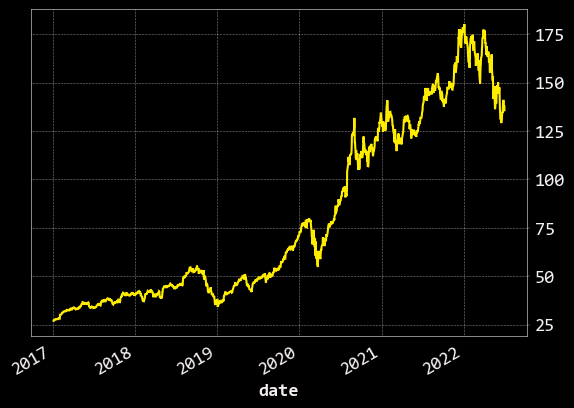

In [8]:
# Will plot the data from "returns"
data['Adj Close'].plot()

In [17]:
# Parkinson's volatility: Uses the high and low of the day
# Good for looking for large swings in price.
def parkinson(price_data, window = 30, trading_periods = 252, clean = True):
    rs = (1.0  / (4.0 * math.log(2.0))) * ((price_data["High"] / price_data["Low"]).apply(np.log)) ** 2.0

    def f(v):
        return (trading_periods * v.mean()) ** 0.5
    
    result = rs.rolling(window = window, center = False).apply(func = f)

    if clean:
        return result.dropna()
    else:
        return  result


<Axes: xlabel='date'>

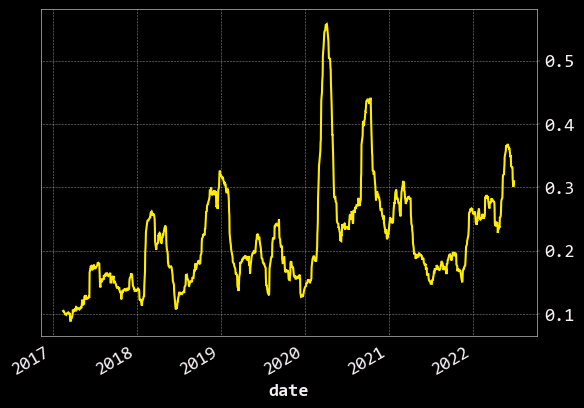

In [18]:
parkinson(data).plot()

In [20]:
# Garman-Klass's volatility: Is similar to Parkinson's Volatility, however uses the 
# opening and closing prices, justification is the most active parts of the day is the
# open and close
def garman_klass(price_data, window = 30, trading_periods = 252, clean = True):
    log_h1 = (price_data["High"] / price_data["Low"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = 0.5 * log_h1 ** 2 - (2 * math.log(2) - 1) * log_co ** 2

    def f(v):
        return (trading_periods * v.mean()) ** 0.5
    
    result = rs.rolling(window = window, center = False).apply(func = f)

    if clean:
        return result.dropna()
    
    else:
        return result

<Axes: xlabel='date'>

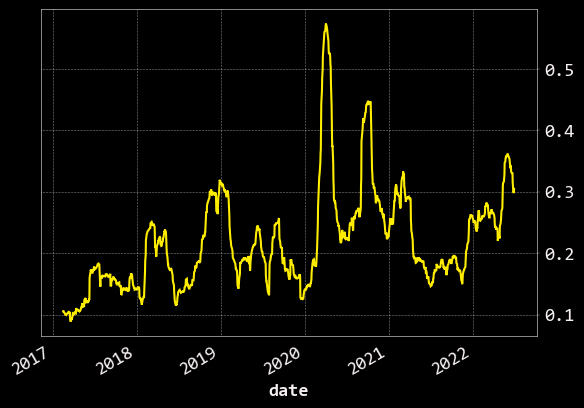

In [21]:
 garman_klass(data).plot()

In [22]:
# Hodges-Tompkins' volatility: a bias corrector for estimation using 
# an overlapping data sample that produces unbiased estimates and 
# a substantial gain in efficiency.
def hodges_tompkins(price_data, window = 30, trading_periods = 252, clean = True):
    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    vol = log_return.rolling(window = window, center = False).std() * math.sqrt(trading_periods)

    h = window
    n = (log_return.count() - h) + 1

    adj_factor = 1.0 / (1.0 - (h / n) + ((h ** 2 - 1) / 3 * n **2))

    result = vol * adj_factor

    if clean:
        return result.dropna()
    else:
        return

<Axes: xlabel='date'>

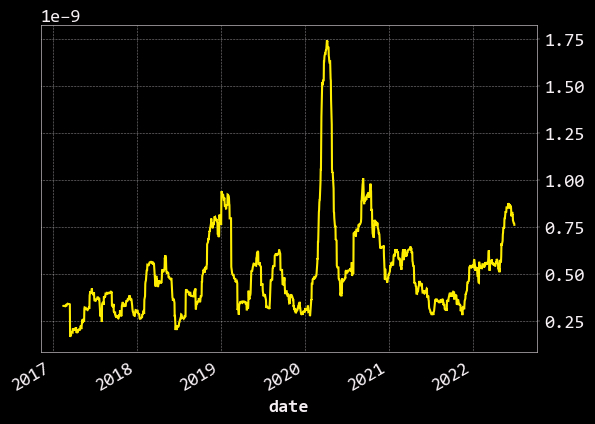

In [23]:
hodges_tompkins(data).plot()

In [26]:
# Rogers-Satchell: is an estimator for measuring the volatility of securities 
# with an average return not equal to zero. Unlike Parkinson and Garman-Klass estimators, 
# Rogers-Satchell incorporates a drift term (mean return not equal to zero).
def rogers_satchell(price_data, window = 30, trading_periods = 252, clean = True):

    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = log_ho * (log_ho - log_co) +  log_lo * (log_lo - log_co)

    def f(v):
        return (trading_periods * v.mean()) ** 0.5
    
    result = rs.rolling(window = window, center = False).apply(func = f)

    if clean:
        return result.dropna()
    else:
        return result

<Axes: xlabel='date'>

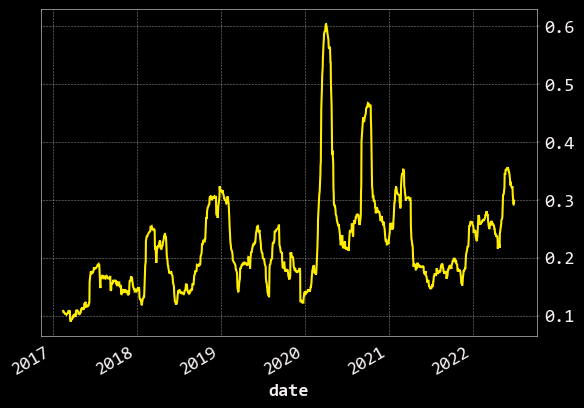

In [27]:
rogers_satchell(data).plot()

In [29]:
# Yang-Zhang Volatility: uses overnight volatility (Close to Open volatility),
# a weighted average of the Rogers-Satchell Volatility and
# the days open-to-close volatility.
def yang_zhang(price_data, window = 30,  trading_periods = 252, clean = True):
    
    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    log_oc = (price_data["Open"] / price_data["Close"].shift(1)).apply(np.log)
    log_oc_sq = log_oc ** 2

    log_cc = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)
    log_cc_sq = log_cc ** 2

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    close_vol = log_cc_sq.rolling(window = window, center = False).sum() * (
        1.0 / (window - 1)
    )
    open_vol = log_oc_sq.rolling(window = window, center = False).sum() * (1.0 / (window - 1.0))

    windows_rs = rs.rolling(window = window, center = False).sum() * (1.0 / (window - 1.0))

    k = 0.34 / (1.34 + (window +  1) / (window - 1))
    result = (open_vol + k * close_vol + (1-k) * windows_rs).apply(
        np.sqrt
    ) * math.sqrt(trading_periods)

    if clean:
        return result.dropna()
    else:
        return result

<Axes: xlabel='date'>

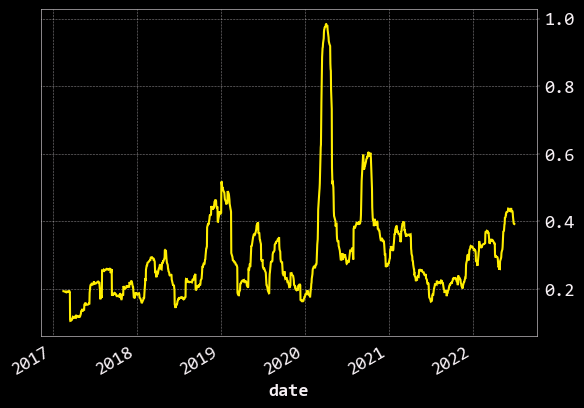

In [30]:
yang_zhang(data).plot()

In [32]:
# Standard Deviation Measures how widely returns are dispersed from the average return
# The most common (and biased) estimator of volatility.
def standard_deviation(price_data, window = 30, trading_periods = 252, clean = True):
    
    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    result = log_return.rolling(window = window, center = False).std() * math.sqrt(
        trading_periods
    )

    if clean:
        return result.dropna()
    else:
        return result

<Axes: xlabel='date'>

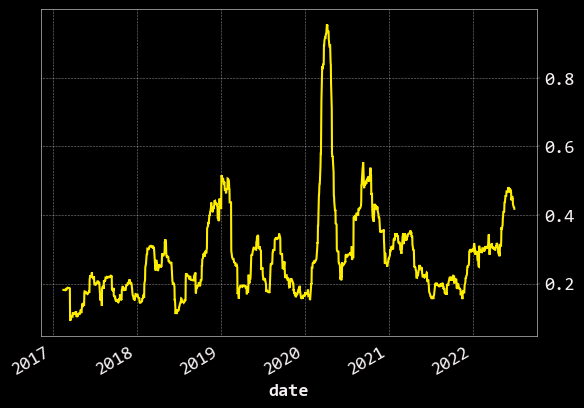

In [33]:
standard_deviation(data).plot()